In [1]:
# import Library and some random image data set
import tensorflow as tf
import numpy      as np
import seaborn    as sns 
import pandas     as pd
import os,sys
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
np.random.seed(78); tf.set_random_seed(78)

# get some of the STL data set
from sklearn.preprocessing import OneHotEncoder
from skimage import util 
from skimage.transform import resize
from skimage.io import imread
import warnings
from numpy import inf

from scipy.stats import kurtosis,skew

plt.rcParams.update({'font.size': 10})
import warnings
warnings.filterwarnings("ignore")
import gc
from IPython.display import display, clear_output
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib import animation
%load_ext jupyternotify

<IPython.core.display.Javascript object>

<h1>Things to compare</h1>
<div>
<ol>
  <li>Z: Baseline </li>
  <li>A: abs(Theta)  </li>
  <li>B: Theta ^ 2</li>
  <li>C: sqrt(Theta ^ 2) </li>
  <li>D: - log(1+Theta ^ 2)</li>
  <li>E: - tanh(Theta) </li>
  <li>F: - tanh(Theta^2)</li>
  <li>G: - tanh(abs(Theta))</li>
  <li>H: - tanh(abs(Theta)^2)</li>
  <li>I:   sin(Theta)</li>
  <li>J:   abs(sin(Theta))</li>
  <li>K:   log(Theta^2)</li>
  <li>L:   Theta * log(Theta^2)</li>
</ol>
</div>

<div>
<ol>
  <li>CNN - no batch </li>
  <li>CNN - batch </li>
  <li>FNN - no batch </li>
  <li>FNN - batch </li>
</ol>
</div>

In [2]:
# CIFAR
# import Library and some random image data set
import tensorflow as tf
import numpy      as np
import seaborn    as sns 
import pandas     as pd
import os,sys
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
np.random.seed(78); tf.set_random_seed(78)

# get some of the STL data set
from sklearn.preprocessing import OneHotEncoder
from skimage import util 
from skimage.transform import resize
from skimage.io import imread
import warnings
from numpy import inf

from scipy.stats import kurtosis,skew

plt.rcParams.update({'font.size': 10})
import warnings
warnings.filterwarnings("ignore")
import gc
from IPython.display import display, clear_output
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib import animation
%load_ext jupyternotify

from sklearn.utils import shuffle
from scipy.misc import imread
from scipy.misc import imresize
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import resize

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [3]:
# read the data
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
PathDicom = "../../../Dataset/cifar-10-batches-py/"
lstFilesDCM = []  # create an empty list
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if not ".html" in filename.lower() and not  ".meta" in filename.lower():  # check whether the file's DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))

# Read the data traind and Test
batch0 = unpickle(lstFilesDCM[0])
batch1 = unpickle(lstFilesDCM[1])
batch2 = unpickle(lstFilesDCM[2])
batch3 = unpickle(lstFilesDCM[3])
batch4 = unpickle(lstFilesDCM[4])

onehot_encoder = OneHotEncoder(sparse=True)
train_batch = np.vstack((batch0[b'data'],batch1[b'data'],batch2[b'data'],batch3[b'data'],batch4[b'data']))
train_label = np.expand_dims(np.hstack((batch0[b'labels'],batch1[b'labels'],batch2[b'labels'],batch3[b'labels'],batch4[b'labels'])).T,axis=1).astype(np.float32)
train_label = onehot_encoder.fit_transform(train_label).toarray().astype(np.float32)

test_batch = unpickle(lstFilesDCM[5])[b'data']
test_label = np.expand_dims(np.array(unpickle(lstFilesDCM[5])[b'labels']),axis=0).T.astype(np.float32)
test_label = onehot_encoder.fit_transform(test_label).toarray().astype(np.float32)

# reshape data
train_batch = np.reshape(train_batch,(len(train_batch),3,32,32))
test_batch = np.reshape(test_batch,(len(test_batch),3,32,32))

# rotate data
train_batch = np.rot90(np.rot90(train_batch,1,axes=(1,3)),3,axes=(1,2)).astype(np.float32)
test_batch = np.rot90(np.rot90(test_batch,1,axes=(1,3)),3,axes=(1,2)).astype(np.float32)

train_images = train_batch/255.0
train_labels = train_label
test_images  = test_batch/255.0
test_labels  = test_label

print(train_images.shape,train_images.max(),train_images.min())
print(train_labels.shape,train_labels.max(),train_labels.min())
print(test_images.shape,test_images.max(),test_images.min())
print(test_labels.shape,test_labels.max(),test_labels.min())

(50000, 32, 32, 3) 1.0 0.0
(50000, 10) 1.0 0.0
(10000, 32, 32, 3) 1.0 0.0
(10000, 10) 1.0 0.0


In [4]:
# create the layers
def tf_softmax(x): return tf.nn.softmax(x)
def tf_relu(x):   return tf.nn.relu(x)
def d_tf_relu(x): return tf.cast(tf.greater(x,0),tf.float32)

class CNN():

    def __init__(self,k,inc,out, stddev=0.05,which_reg=0,act=tf_relu,d_act=d_tf_relu):
        self.w              = tf.Variable(tf.random_normal([k,k,inc,out],stddev=stddev,seed=2,dtype=tf.float32))
        self.m,self.v       = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act
        self.regularizer    = which_reg
    def getw(self): return self.w
    def feedforward(self,input,stride=1,padding='SAME'):
        self.input  = input
        self.layer  = tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding=padding) 
        self.layerA = self.act(self.layer)
        return self.layer, self.layerA
    def backprop(self,gradient,stride=1,padding='SAME'):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2
        grad        = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = tf.shape(self.w),  out_backprop = grad_middle,strides=[1,stride,stride,1],padding=padding) / batch_size
        grad_pass   = tf.nn.conv2d_backprop_input (input_sizes = tf.shape(self.input),filter= self.w,out_backprop = grad_middle,strides=[1,stride,stride,1],padding=padding)

        if self.regularizer == 'A': grad = grad + lamda * tf.sign(self.w)
        if self.regularizer == 'B': grad = grad + lamda * 2.0 * self.w
        if self.regularizer == 'C': grad = grad + lamda * (1.0/tf.sqrt(tf.square(self.w)+ 10e-8)) * self.w
        if self.regularizer == 'D': grad = grad + lamda * -(2*self.w)/(1 + self.w**2)
        if self.regularizer == 'E': grad = grad + lamda * -(1-tf.tanh(self.w) ** 2)
        if self.regularizer == 'F': grad = grad + lamda * -(1-tf.tanh(self.w** 2) ** 2) * 2.0 * self.w 
        if self.regularizer == 'G': grad = grad + lamda * -(1-tf.tanh(tf.abs(self.w)) ** 2) * tf.sign(self.w)
        if self.regularizer == 'H': grad = grad + lamda * -(1-tf.tanh(tf.abs(self.w)** 2) ** 2) * 2.0 * tf.abs(self.w) *  tf.sign(self.w)
        if self.regularizer == 'I': grad = grad + lamda * tf.cos(self.w)
        if self.regularizer == 'J': grad = grad + lamda * tf.sign(tf.sin(self.w)) * tf.cos(self.w)
        if self.regularizer == 'K': grad = grad + lamda * (2)/(self.w + 10e-8)
        if self.regularizer == 'L': grad = grad + lamda * (tf.log(self.w**2) + 2.0)
        
        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1) ; v_hat = self.v / (1-beta2)
        adam_middle = m_hat * learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,adam_middle  )))
        return grad_pass,grad,update_w
class tf_batch_norm_layer():
    
    def __init__(self,vector_shape,axis):
        self.moving_mean = tf.Variable(tf.zeros(shape=[1,1,1,vector_shape],dtype=tf.float32))
        self.moving_vari = tf.Variable(tf.zeros(shape=[1,1,1,vector_shape],dtype=tf.float32))
        self.axis        = axis
    def feedforward(self,input,training_phase=True,eps = 1e-8):
        self.input = input
        self.input_size          = self.input.shape
        self.batch,self.h,self.w,self.c = self.input_size[0].value,self.input_size[1].value,self.input_size[2].value,self.input_size[3].value

        # Training Moving Average Mean         
        def training_fn():
            self.mean    = tf.reduce_mean(self.input,axis=self.axis ,keepdims=True)
            self.var     = tf.reduce_mean(tf.square(self.input-self.mean),axis=self.axis,keepdims=True)
            centered_data= (self.input - self.mean)/tf.sqrt(self.var + eps)
            
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean*0.9 + 0.1 * self.mean ))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari*0.9 + 0.1 * self.var  ))
            return centered_data,update_variable
        
        # Testing Moving Average Mean        
        def  testing_fn():
            centered_data   = (self.input - self.moving_mean)/tf.sqrt(self.moving_vari + eps)
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari))
            return centered_data,update_variable
        
        self.output,update_variable = tf.cond(training_phase,true_fn=training_fn,false_fn=testing_fn)
        return self.output,update_variable
    def backprop(self,grad,eps = 1e-8):
        change_parts = 1.0 /(self.batch * self.h * self.w)
        grad_sigma   = tf.reduce_sum( grad *  (self.input-self.mean)     ,axis=self.axis,keepdims=True) * -0.5 * (self.var+eps) ** -1.5
        grad_mean    = tf.reduce_sum( grad *  (-1./tf.sqrt(self.var+eps)),axis=self.axis,keepdims=True) + grad_sigma * change_parts * 2.0 * tf.reduce_sum((self.input-self.mean),axis=self.axis,keepdims=True) * -1
        grad_x       = grad * 1/(tf.sqrt(self.var+eps)) + grad_sigma * change_parts * 2.0 * (self.input-self.mean) + grad_mean * change_parts
        return grad_x

def save_to_image(data,name):
    l1g,l2g,l3g,l4g,l5g,l6g = data
    l1g,l2g,l3g,l4g,l5g,l6g = np.asarray(l1g),np.asarray(l2g),np.asarray(l3g),np.asarray(l4g),np.asarray(l5g),np.asarray(l6g)
    plt.figure(figsize=(25,15))
    plt.suptitle('Current Iter : ' + str(iter))
    plt.subplot(231); plt.hist(l1g.ravel(),50); plt.title('layer 1')
    plt.subplot(232); plt.hist(l2g.ravel(),50); plt.title('layer 2')
    plt.subplot(233); plt.hist(l3g.ravel(),50); plt.title('layer 3')
    plt.subplot(234); plt.hist(l4g.ravel(),50); plt.title('layer 4')
    plt.subplot(235); plt.hist(l5g.ravel(),50); plt.title('layer 5')
    plt.subplot(236); plt.hist(l6g.ravel(),50); plt.title('layer 6')
    plt.savefig(name + str(iter)+'.png')
    plt.tight_layout()
    plt.close('all')     
def append_stat(current_list,data,number):
    current_list[0].append(data[number].mean())
    current_list[1].append(data[number].std())
    current_list[2].append(skew    (data[number].ravel()))
    current_list[3].append(kurtosis(data[number].ravel()))
    current_list[4].append(np.count_nonzero(data[number]))
    return current_list
def transform_to_2d(data):
    batch,width,height,chan = data.shape
    return data.reshape((batch*width,height*chan))
def save_to_image(main_data,one,two,three,four,five,six,experiment_name,tran_acc,test_acc,current_exp,iter):
    plt.figure(figsize=(20,40))
    G = gridspec.GridSpec(8, 6)

    plt.figtext(0.5,1.0,"Iter: " + str(iter) + " Histogram Per " + experiment_name,ha="center", va="top", fontsize=35, color="black")
    plt.subplot(G[0, 0]).hist(main_data[0].ravel(),50,color='red');       plt.subplot(G[0, 0]).set_title(experiment_name+' 1')
    plt.subplot(G[0, 1]).hist(main_data[1].ravel(),50,color='orange');    plt.subplot(G[0, 1]).set_title(experiment_name+' 2')
    plt.subplot(G[0, 2]).hist(main_data[2].ravel(),50,color='yellow');  plt.subplot(G[0, 2]).set_title(experiment_name+' 3')
    plt.subplot(G[0, 3]).hist(main_data[3].ravel(),50,color='green');    plt.subplot(G[0, 3]).set_title(experiment_name+' 4')
    plt.subplot(G[0, 4]).hist(main_data[4].ravel(),50,color='blue');     plt.subplot(G[0, 4]).set_title(experiment_name+' 5')
    plt.subplot(G[0, 5]).hist(main_data[5].ravel(),50,color='black');     plt.subplot(G[0, 5]).set_title(experiment_name+' 6')

    plt.subplot(G[1, :]).set_title("Mean Per "+ experiment_name)
    plt.subplot(G[1, :]).plot(one[0]  ,c='red',alpha=0.9,label='1')
    plt.subplot(G[1, :]).plot(two[0]  ,c='orange',alpha=0.9,label='2')
    plt.subplot(G[1, :]).plot(three[0],c='yellow',alpha=0.9,label='3')
    plt.subplot(G[1, :]).plot(four[0],c='green',alpha=0.9,label='4')
    plt.subplot(G[1, :]).plot(five[0],c='blue',alpha=0.9,label='5')
    plt.subplot(G[1, :]).plot(six[0],c='black',alpha=0.9,label='6')
    plt.legend(bbox_to_anchor=(0., 0.95, 1., .05), loc=9,ncol=6, mode="expand", borderaxespad=0.)

    plt.subplot(G[2, :]).set_title("Standard Deviation Per "+ experiment_name)
    plt.subplot(G[2, :]).plot(one[1]  ,c='red',alpha=0.9,label='1')
    plt.subplot(G[2, :]).plot(two[1]  ,c='orange',alpha=0.9,label='2')
    plt.subplot(G[2, :]).plot(three[1],c='yellow',alpha=0.9,label='3')
    plt.subplot(G[2, :]).plot(four[1],c='green',alpha=0.9,label='4')
    plt.subplot(G[2, :]).plot(five[1],c='blue',alpha=0.9,label='5')
    plt.subplot(G[2, :]).plot(six[1],c='black',alpha=0.9,label='6')
    plt.legend(bbox_to_anchor=(0., 0.95, 1., .05), loc=9,ncol=6, mode="expand", borderaxespad=0.)

    plt.subplot(G[3, :]).set_title("Skewness Per "+ experiment_name)
    plt.subplot(G[3, :]).plot(one[2]  ,c='red',alpha=0.9,label='1')
    plt.subplot(G[3, :]).plot(two[2]  ,c='orange',alpha=0.9,label='2')
    plt.subplot(G[3, :]).plot(three[2],c='yellow',alpha=0.9,label='3')
    plt.subplot(G[3, :]).plot(four[2],c='green',alpha=0.9,label='4')
    plt.subplot(G[3, :]).plot(five[2],c='blue',alpha=0.9,label='5')
    plt.subplot(G[3, :]).plot(six[2],c='black',alpha=0.9,label='6')
    plt.legend(bbox_to_anchor=(0., 0.95, 1., .05), loc=9,ncol=6, mode="expand", borderaxespad=0.)

    plt.subplot(G[4, :]).set_title("Kurtosis Per "+ experiment_name)
    plt.subplot(G[4, :]).plot(one[3]  ,c='red',alpha=0.9,label='1')
    plt.subplot(G[4, :]).plot(two[3]  ,c='orange',alpha=0.9,label='2')
    plt.subplot(G[4, :]).plot(three[3],c='yellow',alpha=0.9,label='3')
    plt.subplot(G[4, :]).plot(four[3],c='green',alpha=0.9,label='4')
    plt.subplot(G[4, :]).plot(five[3],c='blue',alpha=0.9,label='5')
    plt.subplot(G[4, :]).plot(six[3],c='black',alpha=0.9,label='6')
    plt.legend(bbox_to_anchor=(0., 0.95, 1., .05), loc=9,ncol=6, mode="expand", borderaxespad=0.)

    plt.subplot(G[5, :]).set_title("# Non-Zero Per "+ experiment_name)
    plt.subplot(G[5, :]).plot(one[4]  ,c='red',alpha=0.9   ,label='1')
    plt.subplot(G[5, :]).plot(two[4]  ,c='orange',alpha=0.9,label='2')
    plt.subplot(G[5, :]).plot(three[4],c='yellow',alpha=0.9,label='3')
    plt.subplot(G[5, :]).plot(four[4],c='green',alpha=0.9  ,label='4')
    plt.subplot(G[5, :]).plot(five[4],c='blue',alpha=0.9   ,label='5')
    plt.subplot(G[5, :]).plot(six[4],c='black',alpha=0.9   ,label='6')
    plt.legend(bbox_to_anchor=(0., 0.95, 1., .05), loc=9,ncol=6, mode="expand", borderaxespad=0.)

    plt.subplot(G[6, :]).set_title("Train/Test accuracy")
    plt.subplot(G[6, :]).plot(train_acc  ,c='red',alpha=0.9, label='Train')
    plt.subplot(G[6, :]).plot(test_acc   ,c='blue',alpha=0.9,label='Test')
    plt.legend()

    plt.figtext(0.5,0,"Correlation Matrix Per "+ experiment_name,ha="center", va="bottom", fontsize=30, color="black")
    plt.subplot(G[7, 0]).imshow(np.corrcoef(transform_to_2d(main_data[0])),cmap='gray')
    plt.subplot(G[7, 1]).imshow(np.corrcoef(transform_to_2d(main_data[1])),cmap='gray')
    plt.subplot(G[7, 2]).imshow(np.corrcoef(transform_to_2d(main_data[2])),cmap='gray')
    plt.subplot(G[7, 3]).imshow(np.corrcoef(transform_to_2d(main_data[3])),cmap='gray')
    plt.subplot(G[7, 4]).imshow(np.corrcoef(transform_to_2d(main_data[4])),cmap='gray')
    plt.subplot(G[7, 5]).imshow(np.corrcoef(transform_to_2d(main_data[5])),cmap='gray')

    plt.tight_layout()
    plt.savefig(current_exp + '/' + experiment_name + '/' + str(iter) + '.png')
    plt.close('all')
def plot_rotation_weight(current_layers,current_layer_number,current_batch_norm_type,current_exp_name): 

    def rotate(angle):ax.view_init(azim=angle)
    plt.rcParams.update({'font.size': 8})
    colors = ['red','orange','yellow','green','blue','purple','black','gold','silver','cyan','pink']
    number_of_eps = [1,2,3,4,5,6,7,8,9,10,11]
    fig = plt.figure(figsize=(10,10))
    ax  = fig.add_subplot(111, projection='3d')
    count = 0
    for episode in range(num_eps+1):
        if episode == num_eps:
            ys   = current_layers.mean(0).flatten()
            xmin = ys.min(); xmax = ys.max(); step = 0.005
            hist,bins = np.histogram(ys, bins=np.linspace(xmin, xmax, (xmax-xmin)/step))
            ax.bar(bins[:-1], hist, width=0.01,zs=episode, zdir='y', color=colors[episode], alpha=0.8)
        else:
            ys   = current_layers[episode].flatten()
            xmin = ys.min(); xmax = ys.max(); step = 0.005
            hist,bins = np.histogram(ys, bins=np.linspace(xmin, xmax, (xmax-xmin)/step))
            ax.bar(bins[:-1], hist, width=0.01,zs=episode, zdir='y', color=colors[episode], alpha=0.4)
    ax.set_xlabel('Values')
    ax.set_ylabel('Episode')
    ax.get_yaxis().set_ticks(np.arange(num_eps+1))
    ax.set_zlabel('Histogram')

    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    # ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    #plt.tight_layout()
    plt.show()

    animation.FuncAnimation(fig, rotate, frames=np.arange(0,362,2),interval=100) \
    .save(str(current_batch_norm_type)+'/'+str(current_exp_name)+'/weight_'+str(current_layer_number)+'.gif', dpi=80, writer='imagemagick')
    plt.close('all')
def plot_image_weight(current_layers,current_layer_number,current_batch_norm_type,current_exp_name,current_exp_train_accuracy,current_exp_test_accuracy):
    colors = ['red','orange','yellow','green','blue','purple','black','gold','silver','cyan','pink']
    def rt(number): return np.around(number,4)
    plt.style.use('seaborn')
    fig = plt.figure(figsize=(15,15))
    plt.rcParams.update({'font.size': 50})

    fig.add_subplot(341); plt.hist(current_layers[0].flatten(),50,color=colors[0],alpha=0.8);plt.title('EPS: 1 Mean: '+str(rt(current_layers[0].mean())) +' STD: '+str(rt(current_layers[0].std())))
    fig.add_subplot(342); plt.hist(current_layers[1].flatten(),50,color=colors[1],alpha=0.8);plt.title('EPS: 2 Mean: '+str(rt(current_layers[1].mean())) +' STD: '+str(rt(current_layers[1].std())))
    fig.add_subplot(343); plt.hist(current_layers[2].flatten(),50,color=colors[2],alpha=0.8);plt.title('EPS: 3 Mean: '+str(rt(current_layers[2].mean())) +' STD: '+str(rt(current_layers[2].std())))
    fig.add_subplot(344); plt.hist(current_layers[3].flatten(),50,color=colors[3],alpha=0.8);plt.title('EPS: 4 Mean: '+str(rt(current_layers[3].mean())) +' STD: '+str(rt(current_layers[3].std())))
    
    fig.add_subplot(345); plt.hist(current_layers[4].flatten(),50,color=colors[4],alpha=0.8);plt.title('EPS: 5 Mean: '+str(rt(current_layers[4].mean())) +' STD: '+str(rt(current_layers[4].std())))
    fig.add_subplot(346); plt.hist(current_layers[5].flatten(),50,color=colors[5],alpha=0.8);plt.title('EPS: 6 Mean: '+str(rt(current_layers[5].mean())) +' STD: '+str(rt(current_layers[5].std())))
    fig.add_subplot(347); plt.hist(current_layers[6].flatten(),50,color=colors[6],alpha=0.8);plt.title('EPS: 7 Mean: '+str(rt(current_layers[6].mean())) +' STD: '+str(rt(current_layers[6].std())))
    fig.add_subplot(348); plt.hist(current_layers[7].flatten(),50,color=colors[7],alpha=0.8);plt.title('EPS: 8 Mean: '+str(rt(current_layers[7].mean())) +' STD: '+str(rt(current_layers[7].std())))
    
    fig.add_subplot(3,4,9);  plt.hist(current_layers[8].flatten(),50,color=colors[8],alpha=0.8);plt.title('EPS: 9 Mean: '+str(rt(current_layers[8].mean())) +' STD: '+str(rt(current_layers[8].std())))
    fig.add_subplot(3,4,10); plt.hist(current_layers[9].flatten(),50,color=colors[9],alpha=0.8);plt.title('EPS: 10 Mean: '+str(rt(current_layers[9].mean())) +' STD: '+str(rt(current_layers[9].std())))
    fig.add_subplot(3,4,11); plt.hist(current_layers.mean(0).flatten(),50,color=colors[10],alpha=0.8);plt.title('EPS: All Mean: '+str(rt(current_layers.mean(0).mean())) +' STD: '+str(rt(current_layers.mean(0).std())))
    fig.add_subplot(3,4,12); 
    plt.plot(current_exp_train_accuracy.max(0),  ' ' ,color='red')
    plt.plot(current_exp_train_accuracy.mean(0), '-' ,color='red',label='train mean')
    plt.plot(current_exp_train_accuracy.min(0) , ' ' ,color='red')
    plt.fill_between(range(num_epoch),current_exp_train_accuracy.max(0),current_exp_train_accuracy.min(0),facecolor='red', alpha=0.2)

    plt.plot(current_exp_test_accuracy.max(0),  ' ' ,color='blue')
    plt.plot(current_exp_test_accuracy.mean(0), '-' ,color='blue',label='test mean')
    plt.plot(current_exp_test_accuracy.min(0) , ' ' ,color='blue')
    plt.fill_between(range(num_epoch),current_exp_test_accuracy.max(0),current_exp_test_accuracy.min(0),facecolor='blue', alpha=0.2)
    
    plt.legend()
    plt.tight_layout()
    plt.savefig(str(current_batch_norm_type)+'/'+str(current_exp_name)+'/weight_'+str(current_layer_number)+'.png')
    plt.close('all')
def plot_full_weight(current_weights_layer1,current_weights_layer2,current_weights_layer3,
                     current_weights_layer4,current_weights_layer5,current_weights_layer6,
                     current_batch_norm_type,current_exp_name,current_exp_train_accuracy,current_exp_test_accuracy):
    
    colors = ['red','orange','yellow','green','blue','purple','black','gold','silver','cyan','pink']
    def rt(number): return np.around(number,4)
    plt.style.use('seaborn')
    fig = plt.figure(figsize=(15,15))
    plt.rcParams.update({'font.size': 50})
    gs = gridspec.GridSpec(3, 3)
    
    fig.add_subplot(331); plt.hist(current_weights_layer1.mean(0).flatten(),50,color=colors[0],alpha=0.8); plt.title('Layer 1 Histogram Mean :'+str(rt(current_weights_layer1.mean(0).mean()))+' STD: '+str(rt(current_weights_layer1.mean(0).std())))
    fig.add_subplot(332); plt.hist(current_weights_layer2.mean(0).flatten(),50,color=colors[1],alpha=0.8); plt.title('Layer 2 Histogram Mean :'+str(rt(current_weights_layer2.mean(0).mean()))+' STD: '+str(rt(current_weights_layer2.mean(0).std())))
    fig.add_subplot(333); plt.hist(current_weights_layer3.mean(0).flatten(),50,color=colors[2],alpha=0.8); plt.title('Layer 3 Histogram Mean :'+str(rt(current_weights_layer3.mean(0).mean()))+' STD: '+str(rt(current_weights_layer3.mean(0).std())))
    
    fig.add_subplot(334); plt.hist(current_weights_layer4.mean(0).flatten(),50,color=colors[3],alpha=0.8); plt.title('Layer 4 Histogram Mean :'+str(rt(current_weights_layer4.mean(0).mean()))+' STD: '+str(rt(current_weights_layer4.mean(0).std())))
    fig.add_subplot(335); plt.hist(current_weights_layer5.mean(0).flatten(),50,color=colors[4],alpha=0.8); plt.title('Layer 5 Histogram Mean :'+str(rt(current_weights_layer5.mean(0).mean()))+' STD: '+str(rt(current_weights_layer5.mean(0).std())))
    fig.add_subplot(336); plt.hist(current_weights_layer6.mean(0).flatten(),50,color=colors[5],alpha=0.8); plt.title('Layer 6 Histogram Mean :'+str(rt(current_weights_layer6.mean(0).mean()))+' STD: '+str(rt(current_weights_layer6.mean(0).std())))
    
    fig.add_subplot(gs[2,:]); 
    plt.plot(current_exp_train_accuracy.max(0),  ' ' ,color='red')
    plt.plot(current_exp_train_accuracy.mean(0), '-' ,color='red',label='train mean')
    plt.plot(current_exp_train_accuracy.min(0) , ' ' ,color='red')
    plt.fill_between(range(num_epoch),current_exp_train_accuracy.max(0),current_exp_train_accuracy.min(0),facecolor='red', alpha=0.2)

    plt.plot(current_exp_test_accuracy.max(0),  ' ' ,color='blue')
    plt.plot(current_exp_test_accuracy.mean(0), '-' ,color='blue',label='test mean')
    plt.plot(current_exp_test_accuracy.min(0) , ' ' ,color='blue')
    plt.fill_between(range(num_epoch),current_exp_test_accuracy.max(0),current_exp_test_accuracy.min(0),facecolor='blue', alpha=0.2)
    
    plt.tight_layout()
    plt.legend()
    plt.savefig(str(current_batch_norm_type)+'/'+str(current_exp_name)+'/z_all.png')
    plt.close('all')
    
def send_notification_email(letter,episode):
    import smtplib, ssl

    port = 587  # For starttls
    smtp_server = "smtp.gmail.com"
    sender_email = "sendresultsforme@gmail.com"
    receiver_email = "jae.duk.seo@gmail.com"
    password = "Password123*"
    message = "Subject: " + str(letter) + " : "+str(episode)+" is done!"

    context = ssl.create_default_context()
    with smtplib.SMTP(smtp_server, port) as server:
        server.ehlo()  # Can be omitted
        server.starttls(context=context)
        server.ehlo()  # Can be omitted
        server.login(sender_email, password)
        server.sendmail(sender_email, receiver_email, message)

In [5]:
# set hyper parameter
plt.rcParams.update({'font.size': 25})
num_eps   = 3; num_epoch = 100; learning_rate = 0.0008; batch_size = 100; beta1,beta2,adam_e = 0.9,0.999,1e-9; lamda = 0.00001


                    Starting Episode: 0

Current : 0	 Train Acc : 0.209	 Test Acc : 0.271	0.2150.15
Current : 50	 Train Acc : 0.473	 Test Acc : 0.451	0.329
Z  Current Iter : 99/100 batch : 9900/10000 acc : 0.371
                    Starting Episode: 1

Current : 0	 Train Acc : 0.219	 Test Acc : 0.304	0.2730.15
Current : 50	 Train Acc : 0.519	 Test Acc : 0.494	0.484
Z  Current Iter : 99/100 batch : 9900/10000 acc : 0.529
                    Starting Episode: 2

Current : 0	 Train Acc : 0.219	 Test Acc : 0.295	0.2560.15
Current : 50	 Train Acc : 0.561	 Test Acc : 0.535	0.458


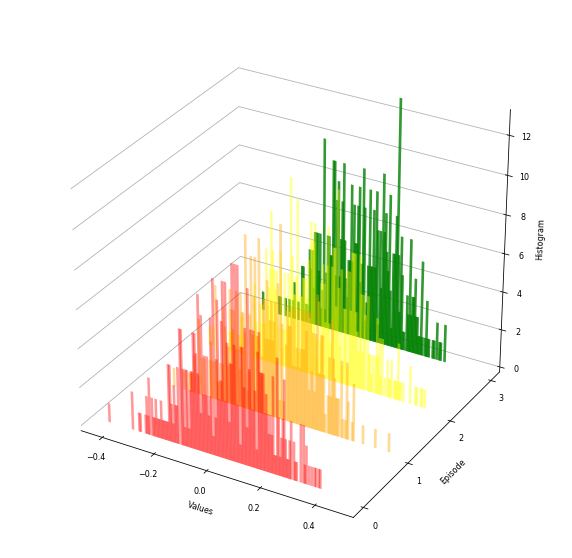

Z  1


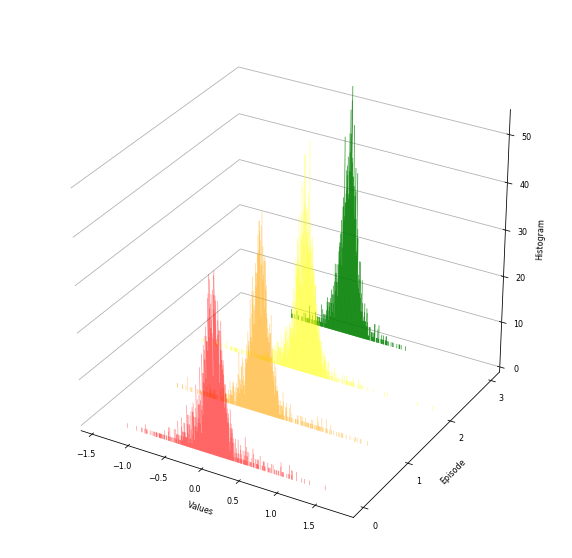

Z  2


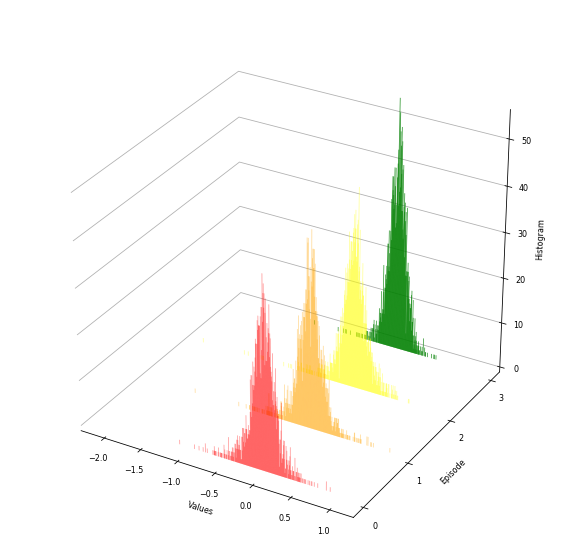

Z  3


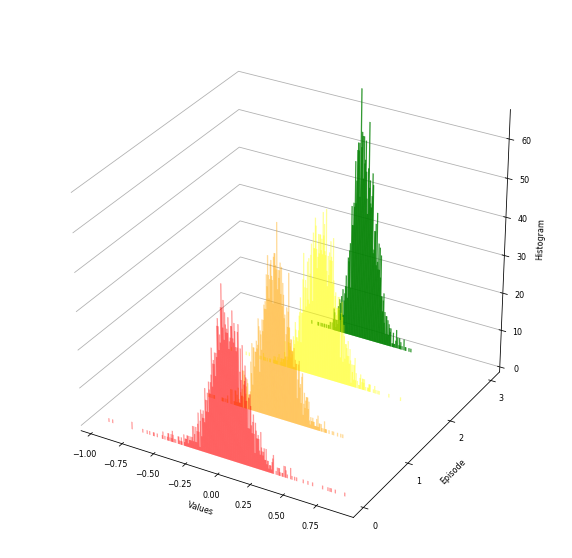

In [ ]:
# all the experiemnt (no batch)
current_batch_norm_type = 'no_batch_cnn_CIFAR'
all_the_exp = ['Z','A','B','C','D','E','F','G','H','I','J','K','L']
for letter in all_the_exp:
    current_exp_name = letter
    sess = tf.InteractiveSession()
    current_exp_train_accuracy = np.zeros((num_eps,num_epoch))
    current_exp_test_accuracy  = np.zeros((num_eps,num_epoch))
    current_weights_layer1 = np.zeros((num_eps,3,3,3,16))
    current_weights_layer2 = np.zeros((num_eps,3,3,16,16))
    current_weights_layer3 = np.zeros((num_eps,3,3,16,16))
    current_weights_layer4 = np.zeros((num_eps,3,3,16,16))
    current_weights_layer5 = np.zeros((num_eps,3,3,16,16))
    current_weights_layer6 = np.zeros((num_eps,3,3,16,10))

    for episode in range(num_eps):
        sys.stdout.write("""
        ================================================
                    Starting Episode: """ + str(episode) +  """
        ================================================\n
        """);sys.stdout.flush();

        # create layers
        l1 = CNN(3,3, 16,which_reg=current_exp_name); 
        l2 = CNN(3,16,16,which_reg=current_exp_name); 
        l3 = CNN(3,16,16,which_reg=current_exp_name); 

        l4 = CNN(3,16,16,which_reg=current_exp_name); 
        l5 = CNN(3,16,16,which_reg=current_exp_name); 
        l6 = CNN(3,16,10,which_reg=current_exp_name); 

        # 2. graph 
        x = tf.placeholder(tf.float32,(batch_size,32,32,3))
        y = tf.placeholder(tf.float32,(batch_size,10))

        layer1, layer1a = l1. feedforward(x,stride=2)
        layer2, layer2a = l2. feedforward(layer1a,stride=2)
        layer3, layer3a = l3. feedforward(layer2a,stride=2)
        layer4, layer4a = l4. feedforward(layer3a,stride=2)
        layer5, layer5a = l5. feedforward(layer4a)
        layer6, layer6a = l6. feedforward(layer5a)

        final_layer   = tf.reduce_mean(layer6a,(1,2))
        final_softmax = tf_softmax(final_layer)
        cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
        correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
        accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,2,2,1])/batch_size
        grad6p,grad6w,grad6_up = l6.backprop(gradient)
        grad5p,grad5w,grad5_up = l5.backprop(grad6p)
        grad4p,grad4w,grad4_up = l4.backprop(grad5p,stride=2)
        grad3p,grad3w,grad3_up = l3.backprop(grad4p,stride=2)
        grad2p,grad2w,grad2_up = l2.backprop(grad3p,stride=2)
        grad1p,grad1w,grad1_up = l1.backprop(grad2p,stride=2)

        gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

        # train
        sess.run(tf.global_variables_initializer())
        avg_acc_train = 0; avg_acc_test  = 0; train_acc = [];test_acc = []

        for iter in range(num_epoch):

            # Training Accuracy    
            for current_batch_index in range(0,len(train_images),batch_size):
                current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
                current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
                sess_results  = sess.run([accuracy,gradient_update],feed_dict={x:current_data,y:current_label})
                sys.stdout.write(str(letter)+ ' '+' Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
                sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]

            # Test Accuracy    
            for current_batch_index in range(0,len(test_images), batch_size):
                current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
                current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
                sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label})
                sys.stdout.write(str(letter)+ ' '+' Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
                sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   

            # ======================== print reset ========================
            train_acc.append(avg_acc_train/(len(train_images)/batch_size))
            test_acc .append(avg_acc_test / (len(test_images)/batch_size))
            if iter%50 == 0 :
                sys.stdout.write("Current : "+ str(iter) + "\t" +
                      " Train Acc : " + str(np.around(avg_acc_train/(len(train_images)/batch_size),3)) + "\t" +
                      " Test Acc : "  + str(np.around(avg_acc_test/(len(test_images)/batch_size),3)) + "\t\n")
                sys.stdout.flush();
            avg_acc_train = 0 ; avg_acc_test  = 0
            # ======================== print reset ========================

        # save to episode all of them
        current_exp_train_accuracy[episode,:] = train_acc; current_exp_test_accuracy[episode,:] = test_acc
        current_weights_layer1[episode] = l1.getw().eval()
        current_weights_layer2[episode] = l2.getw().eval()
        current_weights_layer3[episode] = l3.getw().eval()
        current_weights_layer4[episode] = l4.getw().eval()
        current_weights_layer5[episode] = l5.getw().eval()
        current_weights_layer6[episode] = l6.getw().eval()
        
        # send me
        try: 
            send_notification_email(letter,episode)
        except: 
            pass
        
    sess.close()

    # save to gif
    plot_rotation_weight(current_weights_layer1,'1',current_batch_norm_type,current_exp_name); print(letter,' 1')
    plot_rotation_weight(current_weights_layer2,'2',current_batch_norm_type,current_exp_name); print(letter,' 2')
    plot_rotation_weight(current_weights_layer3,'3',current_batch_norm_type,current_exp_name); print(letter,' 3')
    plot_rotation_weight(current_weights_layer4,'4',current_batch_norm_type,current_exp_name); print(letter,' 4')
    plot_rotation_weight(current_weights_layer5,'5',current_batch_norm_type,current_exp_name); print(letter,' 5')
    plot_rotation_weight(current_weights_layer6,'6',current_batch_norm_type,current_exp_name); print(letter,' 6')

    # save to image
    plot_image_weight(current_weights_layer1,'1',current_batch_norm_type,current_exp_name,current_exp_train_accuracy,current_exp_test_accuracy)
    plot_image_weight(current_weights_layer2,'2',current_batch_norm_type,current_exp_name,current_exp_train_accuracy,current_exp_test_accuracy)
    plot_image_weight(current_weights_layer3,'3',current_batch_norm_type,current_exp_name,current_exp_train_accuracy,current_exp_test_accuracy)
    plot_image_weight(current_weights_layer4,'4',current_batch_norm_type,current_exp_name,current_exp_train_accuracy,current_exp_test_accuracy)
    plot_image_weight(current_weights_layer5,'5',current_batch_norm_type,current_exp_name,current_exp_train_accuracy,current_exp_test_accuracy)
    plot_image_weight(current_weights_layer6,'6',current_batch_norm_type,current_exp_name,current_exp_train_accuracy,current_exp_test_accuracy)

    # save all average and accuracy
    plot_full_weight(current_weights_layer1,current_weights_layer2,current_weights_layer3,
                         current_weights_layer4,current_weights_layer5,current_weights_layer6,
                         current_batch_norm_type,current_exp_name,current_exp_train_accuracy,current_exp_test_accuracy)

In [ ]:
# set hyper parameter
plt.rcParams.update({'font.size': 25})
num_eps   = 3; num_epoch = 100; learning_rate = 0.0008; batch_size = 100; beta1,beta2,adam_e = 0.9,0.999,1e-9; lamda = 0.01

In [ ]:
# all the experiemnt (batch)
current_batch_norm_type = 'batch_cnn_CIFAR'
all_the_exp = ['Z','A','B','C','D','E','F','G','H','I','J','K','L']
for letter in all_the_exp:
    current_exp_name = letter
    sess = tf.InteractiveSession()
    current_exp_train_accuracy = np.zeros((num_eps,num_epoch))
    current_exp_test_accuracy  = np.zeros((num_eps,num_epoch))
    current_weights_layer1 = np.zeros((num_eps,3,3,3,16))
    current_weights_layer2 = np.zeros((num_eps,3,3,16,16))
    current_weights_layer3 = np.zeros((num_eps,3,3,16,16))
    current_weights_layer4 = np.zeros((num_eps,3,3,16,16))
    current_weights_layer5 = np.zeros((num_eps,3,3,16,16))
    current_weights_layer6 = np.zeros((num_eps,3,3,16,10))

    for episode in range(num_eps):
        sys.stdout.write("""
        ================================================
                    Starting Episode: """ + str(episode) +  """
        ================================================\n
        """);sys.stdout.flush();

        # create layers
        l1 = CNN(3,3, 16,which_reg=current_exp_name); l1n = tf_batch_norm_layer(16,(0,1,2))
        l2 = CNN(3,16,16,which_reg=current_exp_name); l2n = tf_batch_norm_layer(16,(0,1,2))
        l3 = CNN(3,16,16,which_reg=current_exp_name); l3n = tf_batch_norm_layer(16,(0,1,2))
        
        l4 = CNN(3,16,16,which_reg=current_exp_name); l4n = tf_batch_norm_layer(16,(0,1,2))
        l5 = CNN(3,16,16,which_reg=current_exp_name); l5n = tf_batch_norm_layer(16,(0,1,2))
        l6 = CNN(3,16,10,which_reg=current_exp_name); 

        # 2. graph 
        x = tf.placeholder(tf.float32,(batch_size,32,32,3))
        y = tf.placeholder(tf.float32,(batch_size,10))
        is_train = tf.placeholder_with_default(True,())

        layer1, layer1a = l1. feedforward(x,stride=2)
        layer1b,update1 = l1n.feedforward(layer1a,is_train)
        layer2, layer2a = l2. feedforward(layer1b,stride=2)
        layer2b,update2 = l2n.feedforward(layer2a,is_train)
        layer3, layer3a = l3. feedforward(layer2b,stride=2)
        layer3b,update3 = l3n.feedforward(layer3a,is_train)
        layer4, layer4a = l4. feedforward(layer3b,stride=2)
        layer4b,update4 = l4n.feedforward(layer4a,is_train)
        layer5, layer5a = l5. feedforward(layer4b)
        layer5b,update5 = l5n.feedforward(layer5a,is_train)
        layer6, layer6a = l6. feedforward(layer5b)

        final_layer   = tf.reduce_mean(layer6a,(1,2))
        final_softmax = tf_softmax(final_layer)
        cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
        correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
        accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,2,2,1])/batch_size
        grad6p,grad6w,grad6_up = l6.backprop(gradient)
        grad5n = l5n.backprop(grad6p)
        grad5p,grad5w,grad5_up = l5.backprop(grad5n)
        grad4n = l4n.backprop(grad5p)
        grad4p,grad4w,grad4_up = l4.backprop(grad4n,stride=2)
        grad3n = l3n.backprop(grad4p)
        grad3p,grad3w,grad3_up = l3.backprop(grad3n,stride=2)
        grad2n = l2n.backprop(grad3p)
        grad2p,grad2w,grad2_up = l2.backprop(grad2n,stride=2)
        grad1n = l1n.backprop(grad2p)
        grad1p,grad1w,grad1_up = l1.backprop(grad1n,stride=2)

        update_ops  = update1 + update2 + update3 + update4 + update5
        gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

        # train
        sess.run(tf.global_variables_initializer())
        avg_acc_train = 0; avg_acc_test  = 0; train_acc = [];test_acc = []

        for iter in range(num_epoch):

            # Training Accuracy    
            for current_batch_index in range(0,len(train_images),batch_size):
                current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
                current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
                sess_results  = sess.run([accuracy,gradient_update,update_ops],feed_dict={x:current_data,y:current_label})
                sys.stdout.write(str(letter)+ ' '+' Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
                sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]

            # Test Accuracy    
            for current_batch_index in range(0,len(test_images), batch_size):
                current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
                current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
                sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label,is_train:False})
                sys.stdout.write(str(letter)+ ' '+' Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
                sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   

            # ======================== print reset ========================
            train_acc.append(avg_acc_train/(len(train_images)/batch_size))
            test_acc .append(avg_acc_test / (len(test_images)/batch_size))
            if iter%50 == 0 :
                sys.stdout.write("Current : "+ str(iter) + "\t" +
                      " Train Acc : " + str(np.around(avg_acc_train/(len(train_images)/batch_size),3)) + "\t" +
                      " Test Acc : "  + str(np.around(avg_acc_test/(len(test_images)/batch_size),3)) + "\t\n")
                sys.stdout.flush();
            avg_acc_train = 0 ; avg_acc_test  = 0
            # ======================== print reset ========================

        # save to episode all of them
        current_exp_train_accuracy[episode,:] = train_acc; current_exp_test_accuracy[episode,:] = test_acc
        current_weights_layer1[episode] = l1.getw().eval()
        current_weights_layer2[episode] = l2.getw().eval()
        current_weights_layer3[episode] = l3.getw().eval()
        current_weights_layer4[episode] = l4.getw().eval()
        current_weights_layer5[episode] = l5.getw().eval()
        current_weights_layer6[episode] = l6.getw().eval()
        # send me
        try: 
            send_notification_email(letter,episode)
        except: 
            pass
    sess.close()

    # save to gif
    plot_rotation_weight(current_weights_layer1,'1',current_batch_norm_type,current_exp_name); print(letter,' 1')
    plot_rotation_weight(current_weights_layer2,'2',current_batch_norm_type,current_exp_name); print(letter,' 2')
    plot_rotation_weight(current_weights_layer3,'3',current_batch_norm_type,current_exp_name); print(letter,' 3')
    plot_rotation_weight(current_weights_layer4,'4',current_batch_norm_type,current_exp_name); print(letter,' 4')
    plot_rotation_weight(current_weights_layer5,'5',current_batch_norm_type,current_exp_name); print(letter,' 5')
    plot_rotation_weight(current_weights_layer6,'6',current_batch_norm_type,current_exp_name); print(letter,' 6')

    # save to image
    plot_image_weight(current_weights_layer1,'1',current_batch_norm_type,current_exp_name,current_exp_train_accuracy,current_exp_test_accuracy)
    plot_image_weight(current_weights_layer2,'2',current_batch_norm_type,current_exp_name,current_exp_train_accuracy,current_exp_test_accuracy)
    plot_image_weight(current_weights_layer3,'3',current_batch_norm_type,current_exp_name,current_exp_train_accuracy,current_exp_test_accuracy)
    plot_image_weight(current_weights_layer4,'4',current_batch_norm_type,current_exp_name,current_exp_train_accuracy,current_exp_test_accuracy)
    plot_image_weight(current_weights_layer5,'5',current_batch_norm_type,current_exp_name,current_exp_train_accuracy,current_exp_test_accuracy)
    plot_image_weight(current_weights_layer6,'6',current_batch_norm_type,current_exp_name,current_exp_train_accuracy,current_exp_test_accuracy)

    # save all average and accuracy
    plot_full_weight(current_weights_layer1,current_weights_layer2,current_weights_layer3,
                     current_weights_layer4,current_weights_layer5,current_weights_layer6,
                     current_batch_norm_type,current_exp_name,current_exp_train_accuracy,current_exp_test_accuracy)

In [ ]:
%reset -f

In [ ]:
# FASHION
# import Library and some random image data set
import tensorflow as tf
import numpy      as np
import seaborn    as sns 
import pandas     as pd
import os,sys
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
np.random.seed(78); tf.set_random_seed(78)

# get some of the STL data set
from sklearn.preprocessing import OneHotEncoder
from skimage import util 
from skimage.transform import resize
from skimage.io import imread
import warnings
from numpy import inf

from scipy.stats import kurtosis,skew

plt.rcParams.update({'font.size': 10})
import warnings
warnings.filterwarnings("ignore")
import gc
from IPython.display import display, clear_output
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib import animation
%load_ext jupyternotify

from sklearn.utils import shuffle
from scipy.misc import imread
from scipy.misc import imresize
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import resize

old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.examples.tutorials.mnist import input_data

In [ ]:
# import data
mnist = input_data.read_data_sets('../../../Dataset/FashionMNIST/', one_hot=True)
x_data, train_label, y_data, test_label = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

train_images = x_data.reshape((55000,28,28,1))
train_labels = train_label
test_images  = y_data.reshape((10000,28,28,1))
test_labels  = test_label

print(train_images.shape,train_images.max(),train_images.min())
print(train_labels.shape,train_labels.max(),train_labels.min())
print(test_images.shape,test_images.max(),test_images.min())
print(test_labels.shape,test_labels.max(),test_labels.min())

In [ ]:
# create the layers
def tf_softmax(x): return tf.nn.softmax(x)
def tf_relu(x):   return tf.nn.relu(x)
def d_tf_relu(x): return tf.cast(tf.greater(x,0),tf.float32)

class CNN():

    def __init__(self,k,inc,out, stddev=0.05,which_reg=0,act=tf_relu,d_act=d_tf_relu):
        self.w              = tf.Variable(tf.random_normal([k,k,inc,out],stddev=stddev,seed=2,dtype=tf.float32))
        self.m,self.v       = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act
        self.regularizer    = which_reg
    def getw(self): return self.w
    def feedforward(self,input,stride=1,padding='SAME'):
        self.input  = input
        self.layer  = tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding=padding) 
        self.layerA = self.act(self.layer)
        return self.layer, self.layerA
    def backprop(self,gradient,stride=1,padding='SAME'):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2
        grad        = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = tf.shape(self.w),  out_backprop = grad_middle,strides=[1,stride,stride,1],padding=padding) / batch_size
        grad_pass   = tf.nn.conv2d_backprop_input (input_sizes = tf.shape(self.input),filter= self.w,out_backprop = grad_middle,strides=[1,stride,stride,1],padding=padding)

        if self.regularizer == 'A': grad = grad + lamda * tf.sign(self.w)
        if self.regularizer == 'B': grad = grad + lamda * 2.0 * self.w
        if self.regularizer == 'C': grad = grad + lamda * (1.0/tf.sqrt(tf.square(self.w)+ 10e-8)) * self.w
        if self.regularizer == 'D': grad = grad + lamda * -(2*self.w)/(1 + self.w**2)
        if self.regularizer == 'E': grad = grad + lamda * -(1-tf.tanh(self.w) ** 2)
        if self.regularizer == 'F': grad = grad + lamda * -(1-tf.tanh(self.w** 2) ** 2) * 2.0 * self.w 
        if self.regularizer == 'G': grad = grad + lamda * -(1-tf.tanh(tf.abs(self.w)) ** 2) * tf.sign(self.w)
        if self.regularizer == 'H': grad = grad + lamda * -(1-tf.tanh(tf.abs(self.w)** 2) ** 2) * 2.0 * tf.abs(self.w) *  tf.sign(self.w)
        if self.regularizer == 'I': grad = grad + lamda * tf.cos(self.w)
        if self.regularizer == 'J': grad = grad + lamda * tf.sign(tf.sin(self.w)) * tf.cos(self.w)
        if self.regularizer == 'K': grad = grad + lamda * (2)/(self.w + 10e-8)
        if self.regularizer == 'L': grad = grad + lamda * (tf.log(self.w**2) + 2.0)
        
        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1) ; v_hat = self.v / (1-beta2)
        adam_middle = m_hat * learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,adam_middle  )))
        return grad_pass,grad,update_w
class tf_batch_norm_layer():
    
    def __init__(self,vector_shape,axis):
        self.moving_mean = tf.Variable(tf.zeros(shape=[1,1,1,vector_shape],dtype=tf.float32))
        self.moving_vari = tf.Variable(tf.zeros(shape=[1,1,1,vector_shape],dtype=tf.float32))
        self.axis        = axis
    def feedforward(self,input,training_phase=True,eps = 1e-8):
        self.input = input
        self.input_size          = self.input.shape
        self.batch,self.h,self.w,self.c = self.input_size[0].value,self.input_size[1].value,self.input_size[2].value,self.input_size[3].value

        # Training Moving Average Mean         
        def training_fn():
            self.mean    = tf.reduce_mean(self.input,axis=self.axis ,keepdims=True)
            self.var     = tf.reduce_mean(tf.square(self.input-self.mean),axis=self.axis,keepdims=True)
            centered_data= (self.input - self.mean)/tf.sqrt(self.var + eps)
            
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean*0.9 + 0.1 * self.mean ))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari*0.9 + 0.1 * self.var  ))
            return centered_data,update_variable
        
        # Testing Moving Average Mean        
        def  testing_fn():
            centered_data   = (self.input - self.moving_mean)/tf.sqrt(self.moving_vari + eps)
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari))
            return centered_data,update_variable
        
        self.output,update_variable = tf.cond(training_phase,true_fn=training_fn,false_fn=testing_fn)
        return self.output,update_variable
    def backprop(self,grad,eps = 1e-8):
        change_parts = 1.0 /(self.batch * self.h * self.w)
        grad_sigma   = tf.reduce_sum( grad *  (self.input-self.mean)     ,axis=self.axis,keepdims=True) * -0.5 * (self.var+eps) ** -1.5
        grad_mean    = tf.reduce_sum( grad *  (-1./tf.sqrt(self.var+eps)),axis=self.axis,keepdims=True) + grad_sigma * change_parts * 2.0 * tf.reduce_sum((self.input-self.mean),axis=self.axis,keepdims=True) * -1
        grad_x       = grad * 1/(tf.sqrt(self.var+eps)) + grad_sigma * change_parts * 2.0 * (self.input-self.mean) + grad_mean * change_parts
        return grad_x

def save_to_image(data,name):
    l1g,l2g,l3g,l4g,l5g,l6g = data
    l1g,l2g,l3g,l4g,l5g,l6g = np.asarray(l1g),np.asarray(l2g),np.asarray(l3g),np.asarray(l4g),np.asarray(l5g),np.asarray(l6g)
    plt.figure(figsize=(25,15))
    plt.suptitle('Current Iter : ' + str(iter))
    plt.subplot(231); plt.hist(l1g.ravel(),50); plt.title('layer 1')
    plt.subplot(232); plt.hist(l2g.ravel(),50); plt.title('layer 2')
    plt.subplot(233); plt.hist(l3g.ravel(),50); plt.title('layer 3')
    plt.subplot(234); plt.hist(l4g.ravel(),50); plt.title('layer 4')
    plt.subplot(235); plt.hist(l5g.ravel(),50); plt.title('layer 5')
    plt.subplot(236); plt.hist(l6g.ravel(),50); plt.title('layer 6')
    plt.savefig(name + str(iter)+'.png')
    plt.tight_layout()
    plt.close('all')     
def append_stat(current_list,data,number):
    current_list[0].append(data[number].mean())
    current_list[1].append(data[number].std())
    current_list[2].append(skew    (data[number].ravel()))
    current_list[3].append(kurtosis(data[number].ravel()))
    current_list[4].append(np.count_nonzero(data[number]))
    return current_list
def transform_to_2d(data):
    batch,width,height,chan = data.shape
    return data.reshape((batch*width,height*chan))
def save_to_image(main_data,one,two,three,four,five,six,experiment_name,tran_acc,test_acc,current_exp,iter):
    plt.figure(figsize=(20,40))
    G = gridspec.GridSpec(8, 6)

    plt.figtext(0.5,1.0,"Iter: " + str(iter) + " Histogram Per " + experiment_name,ha="center", va="top", fontsize=35, color="black")
    plt.subplot(G[0, 0]).hist(main_data[0].ravel(),50,color='red');       plt.subplot(G[0, 0]).set_title(experiment_name+' 1')
    plt.subplot(G[0, 1]).hist(main_data[1].ravel(),50,color='orange');    plt.subplot(G[0, 1]).set_title(experiment_name+' 2')
    plt.subplot(G[0, 2]).hist(main_data[2].ravel(),50,color='yellow');  plt.subplot(G[0, 2]).set_title(experiment_name+' 3')
    plt.subplot(G[0, 3]).hist(main_data[3].ravel(),50,color='green');    plt.subplot(G[0, 3]).set_title(experiment_name+' 4')
    plt.subplot(G[0, 4]).hist(main_data[4].ravel(),50,color='blue');     plt.subplot(G[0, 4]).set_title(experiment_name+' 5')
    plt.subplot(G[0, 5]).hist(main_data[5].ravel(),50,color='black');     plt.subplot(G[0, 5]).set_title(experiment_name+' 6')

    plt.subplot(G[1, :]).set_title("Mean Per "+ experiment_name)
    plt.subplot(G[1, :]).plot(one[0]  ,c='red',alpha=0.9,label='1')
    plt.subplot(G[1, :]).plot(two[0]  ,c='orange',alpha=0.9,label='2')
    plt.subplot(G[1, :]).plot(three[0],c='yellow',alpha=0.9,label='3')
    plt.subplot(G[1, :]).plot(four[0],c='green',alpha=0.9,label='4')
    plt.subplot(G[1, :]).plot(five[0],c='blue',alpha=0.9,label='5')
    plt.subplot(G[1, :]).plot(six[0],c='black',alpha=0.9,label='6')
    plt.legend(bbox_to_anchor=(0., 0.95, 1., .05), loc=9,ncol=6, mode="expand", borderaxespad=0.)

    plt.subplot(G[2, :]).set_title("Standard Deviation Per "+ experiment_name)
    plt.subplot(G[2, :]).plot(one[1]  ,c='red',alpha=0.9,label='1')
    plt.subplot(G[2, :]).plot(two[1]  ,c='orange',alpha=0.9,label='2')
    plt.subplot(G[2, :]).plot(three[1],c='yellow',alpha=0.9,label='3')
    plt.subplot(G[2, :]).plot(four[1],c='green',alpha=0.9,label='4')
    plt.subplot(G[2, :]).plot(five[1],c='blue',alpha=0.9,label='5')
    plt.subplot(G[2, :]).plot(six[1],c='black',alpha=0.9,label='6')
    plt.legend(bbox_to_anchor=(0., 0.95, 1., .05), loc=9,ncol=6, mode="expand", borderaxespad=0.)

    plt.subplot(G[3, :]).set_title("Skewness Per "+ experiment_name)
    plt.subplot(G[3, :]).plot(one[2]  ,c='red',alpha=0.9,label='1')
    plt.subplot(G[3, :]).plot(two[2]  ,c='orange',alpha=0.9,label='2')
    plt.subplot(G[3, :]).plot(three[2],c='yellow',alpha=0.9,label='3')
    plt.subplot(G[3, :]).plot(four[2],c='green',alpha=0.9,label='4')
    plt.subplot(G[3, :]).plot(five[2],c='blue',alpha=0.9,label='5')
    plt.subplot(G[3, :]).plot(six[2],c='black',alpha=0.9,label='6')
    plt.legend(bbox_to_anchor=(0., 0.95, 1., .05), loc=9,ncol=6, mode="expand", borderaxespad=0.)

    plt.subplot(G[4, :]).set_title("Kurtosis Per "+ experiment_name)
    plt.subplot(G[4, :]).plot(one[3]  ,c='red',alpha=0.9,label='1')
    plt.subplot(G[4, :]).plot(two[3]  ,c='orange',alpha=0.9,label='2')
    plt.subplot(G[4, :]).plot(three[3],c='yellow',alpha=0.9,label='3')
    plt.subplot(G[4, :]).plot(four[3],c='green',alpha=0.9,label='4')
    plt.subplot(G[4, :]).plot(five[3],c='blue',alpha=0.9,label='5')
    plt.subplot(G[4, :]).plot(six[3],c='black',alpha=0.9,label='6')
    plt.legend(bbox_to_anchor=(0., 0.95, 1., .05), loc=9,ncol=6, mode="expand", borderaxespad=0.)

    plt.subplot(G[5, :]).set_title("# Non-Zero Per "+ experiment_name)
    plt.subplot(G[5, :]).plot(one[4]  ,c='red',alpha=0.9   ,label='1')
    plt.subplot(G[5, :]).plot(two[4]  ,c='orange',alpha=0.9,label='2')
    plt.subplot(G[5, :]).plot(three[4],c='yellow',alpha=0.9,label='3')
    plt.subplot(G[5, :]).plot(four[4],c='green',alpha=0.9  ,label='4')
    plt.subplot(G[5, :]).plot(five[4],c='blue',alpha=0.9   ,label='5')
    plt.subplot(G[5, :]).plot(six[4],c='black',alpha=0.9   ,label='6')
    plt.legend(bbox_to_anchor=(0., 0.95, 1., .05), loc=9,ncol=6, mode="expand", borderaxespad=0.)

    plt.subplot(G[6, :]).set_title("Train/Test accuracy")
    plt.subplot(G[6, :]).plot(train_acc  ,c='red',alpha=0.9, label='Train')
    plt.subplot(G[6, :]).plot(test_acc   ,c='blue',alpha=0.9,label='Test')
    plt.legend()

    plt.figtext(0.5,0,"Correlation Matrix Per "+ experiment_name,ha="center", va="bottom", fontsize=30, color="black")
    plt.subplot(G[7, 0]).imshow(np.corrcoef(transform_to_2d(main_data[0])),cmap='gray')
    plt.subplot(G[7, 1]).imshow(np.corrcoef(transform_to_2d(main_data[1])),cmap='gray')
    plt.subplot(G[7, 2]).imshow(np.corrcoef(transform_to_2d(main_data[2])),cmap='gray')
    plt.subplot(G[7, 3]).imshow(np.corrcoef(transform_to_2d(main_data[3])),cmap='gray')
    plt.subplot(G[7, 4]).imshow(np.corrcoef(transform_to_2d(main_data[4])),cmap='gray')
    plt.subplot(G[7, 5]).imshow(np.corrcoef(transform_to_2d(main_data[5])),cmap='gray')

    plt.tight_layout()
    plt.savefig(current_exp + '/' + experiment_name + '/' + str(iter) + '.png')
    plt.close('all')
def plot_rotation_weight(current_layers,current_layer_number,current_batch_norm_type,current_exp_name): 

    def rotate(angle):ax.view_init(azim=angle)
    plt.rcParams.update({'font.size': 8})
    colors = ['red','orange','yellow','green','blue','purple','black','gold','silver','cyan','pink']
    number_of_eps = [1,2,3,4,5,6,7,8,9,10,11]
    fig = plt.figure(figsize=(10,10))
    ax  = fig.add_subplot(111, projection='3d')
    count = 0
    for episode in range(num_eps+1):
        if episode == num_eps:
            ys   = current_layers.mean(0).flatten()
            xmin = ys.min(); xmax = ys.max(); step = 0.005
            hist,bins = np.histogram(ys, bins=np.linspace(xmin, xmax, (xmax-xmin)/step))
            ax.bar(bins[:-1], hist, width=0.01,zs=episode, zdir='y', color=colors[episode], alpha=0.8)
        else:
            ys   = current_layers[episode].flatten()
            xmin = ys.min(); xmax = ys.max(); step = 0.005
            hist,bins = np.histogram(ys, bins=np.linspace(xmin, xmax, (xmax-xmin)/step))
            ax.bar(bins[:-1], hist, width=0.01,zs=episode, zdir='y', color=colors[episode], alpha=0.4)
    ax.set_xlabel('Values')
    ax.set_ylabel('Episode')
    ax.get_yaxis().set_ticks(np.arange(num_eps+1))
    ax.set_zlabel('Histogram')

    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    # ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    #plt.tight_layout()
    plt.show()

    animation.FuncAnimation(fig, rotate, frames=np.arange(0,362,2),interval=100) \
    .save(str(current_batch_norm_type)+'/'+str(current_exp_name)+'/weight_'+str(current_layer_number)+'.gif', dpi=80, writer='imagemagick')
    plt.close('all')
def plot_image_weight(current_layers,current_layer_number,current_batch_norm_type,current_exp_name,current_exp_train_accuracy,current_exp_test_accuracy):
    colors = ['red','orange','yellow','green','blue','purple','black','gold','silver','cyan','pink']
    def rt(number): return np.around(number,4)
    plt.style.use('seaborn')
    fig = plt.figure(figsize=(15,15))
    plt.rcParams.update({'font.size': 50})

    fig.add_subplot(341); plt.hist(current_layers[0].flatten(),50,color=colors[0],alpha=0.8);plt.title('EPS: 1 Mean: '+str(rt(current_layers[0].mean())) +' STD: '+str(rt(current_layers[0].std())))
    fig.add_subplot(342); plt.hist(current_layers[1].flatten(),50,color=colors[1],alpha=0.8);plt.title('EPS: 2 Mean: '+str(rt(current_layers[1].mean())) +' STD: '+str(rt(current_layers[1].std())))
    fig.add_subplot(343); plt.hist(current_layers[2].flatten(),50,color=colors[2],alpha=0.8);plt.title('EPS: 3 Mean: '+str(rt(current_layers[2].mean())) +' STD: '+str(rt(current_layers[2].std())))
    fig.add_subplot(344); plt.hist(current_layers[3].flatten(),50,color=colors[3],alpha=0.8);plt.title('EPS: 4 Mean: '+str(rt(current_layers[3].mean())) +' STD: '+str(rt(current_layers[3].std())))
    
    fig.add_subplot(345); plt.hist(current_layers[4].flatten(),50,color=colors[4],alpha=0.8);plt.title('EPS: 5 Mean: '+str(rt(current_layers[4].mean())) +' STD: '+str(rt(current_layers[4].std())))
    fig.add_subplot(346); plt.hist(current_layers[5].flatten(),50,color=colors[5],alpha=0.8);plt.title('EPS: 6 Mean: '+str(rt(current_layers[5].mean())) +' STD: '+str(rt(current_layers[5].std())))
    fig.add_subplot(347); plt.hist(current_layers[6].flatten(),50,color=colors[6],alpha=0.8);plt.title('EPS: 7 Mean: '+str(rt(current_layers[6].mean())) +' STD: '+str(rt(current_layers[6].std())))
    fig.add_subplot(348); plt.hist(current_layers[7].flatten(),50,color=colors[7],alpha=0.8);plt.title('EPS: 8 Mean: '+str(rt(current_layers[7].mean())) +' STD: '+str(rt(current_layers[7].std())))
    
    fig.add_subplot(3,4,9);  plt.hist(current_layers[8].flatten(),50,color=colors[8],alpha=0.8);plt.title('EPS: 9 Mean: '+str(rt(current_layers[8].mean())) +' STD: '+str(rt(current_layers[8].std())))
    fig.add_subplot(3,4,10); plt.hist(current_layers[9].flatten(),50,color=colors[9],alpha=0.8);plt.title('EPS: 10 Mean: '+str(rt(current_layers[9].mean())) +' STD: '+str(rt(current_layers[9].std())))
    fig.add_subplot(3,4,11); plt.hist(current_layers.mean(0).flatten(),50,color=colors[10],alpha=0.8);plt.title('EPS: All Mean: '+str(rt(current_layers.mean(0).mean())) +' STD: '+str(rt(current_layers.mean(0).std())))
    fig.add_subplot(3,4,12); 
    plt.plot(current_exp_train_accuracy.max(0),  ' ' ,color='red')
    plt.plot(current_exp_train_accuracy.mean(0), '-' ,color='red',label='train mean')
    plt.plot(current_exp_train_accuracy.min(0) , ' ' ,color='red')
    plt.fill_between(range(num_epoch),current_exp_train_accuracy.max(0),current_exp_train_accuracy.min(0),facecolor='red', alpha=0.2)

    plt.plot(current_exp_test_accuracy.max(0),  ' ' ,color='blue')
    plt.plot(current_exp_test_accuracy.mean(0), '-' ,color='blue',label='test mean')
    plt.plot(current_exp_test_accuracy.min(0) , ' ' ,color='blue')
    plt.fill_between(range(num_epoch),current_exp_test_accuracy.max(0),current_exp_test_accuracy.min(0),facecolor='blue', alpha=0.2)
    
    plt.legend()
    plt.tight_layout()
    plt.savefig(str(current_batch_norm_type)+'/'+str(current_exp_name)+'/weight_'+str(current_layer_number)+'.png')
    plt.close('all')
def plot_full_weight(current_weights_layer1,current_weights_layer2,current_weights_layer3,
                     current_weights_layer4,current_weights_layer5,current_weights_layer6,
                     current_batch_norm_type,current_exp_name,current_exp_train_accuracy,current_exp_test_accuracy):
    
    colors = ['red','orange','yellow','green','blue','purple','black','gold','silver','cyan','pink']
    def rt(number): return np.around(number,4)
    plt.style.use('seaborn')
    fig = plt.figure(figsize=(15,15))
    plt.rcParams.update({'font.size': 50})
    gs = gridspec.GridSpec(3, 3)
    
    fig.add_subplot(331); plt.hist(current_weights_layer1.mean(0).flatten(),50,color=colors[0],alpha=0.8); plt.title('Layer 1 Histogram Mean :'+str(rt(current_weights_layer1.mean(0).mean()))+' STD: '+str(rt(current_weights_layer1.mean(0).std())))
    fig.add_subplot(332); plt.hist(current_weights_layer2.mean(0).flatten(),50,color=colors[1],alpha=0.8); plt.title('Layer 2 Histogram Mean :'+str(rt(current_weights_layer2.mean(0).mean()))+' STD: '+str(rt(current_weights_layer2.mean(0).std())))
    fig.add_subplot(333); plt.hist(current_weights_layer3.mean(0).flatten(),50,color=colors[2],alpha=0.8); plt.title('Layer 3 Histogram Mean :'+str(rt(current_weights_layer3.mean(0).mean()))+' STD: '+str(rt(current_weights_layer3.mean(0).std())))
    
    fig.add_subplot(334); plt.hist(current_weights_layer4.mean(0).flatten(),50,color=colors[3],alpha=0.8); plt.title('Layer 4 Histogram Mean :'+str(rt(current_weights_layer4.mean(0).mean()))+' STD: '+str(rt(current_weights_layer4.mean(0).std())))
    fig.add_subplot(335); plt.hist(current_weights_layer5.mean(0).flatten(),50,color=colors[4],alpha=0.8); plt.title('Layer 5 Histogram Mean :'+str(rt(current_weights_layer5.mean(0).mean()))+' STD: '+str(rt(current_weights_layer5.mean(0).std())))
    fig.add_subplot(336); plt.hist(current_weights_layer6.mean(0).flatten(),50,color=colors[5],alpha=0.8); plt.title('Layer 6 Histogram Mean :'+str(rt(current_weights_layer6.mean(0).mean()))+' STD: '+str(rt(current_weights_layer6.mean(0).std())))
    
    fig.add_subplot(gs[2,:]); 
    plt.plot(current_exp_train_accuracy.max(0),  ' ' ,color='red')
    plt.plot(current_exp_train_accuracy.mean(0), '-' ,color='red',label='train mean')
    plt.plot(current_exp_train_accuracy.min(0) , ' ' ,color='red')
    plt.fill_between(range(num_epoch),current_exp_train_accuracy.max(0),current_exp_train_accuracy.min(0),facecolor='red', alpha=0.2)

    plt.plot(current_exp_test_accuracy.max(0),  ' ' ,color='blue')
    plt.plot(current_exp_test_accuracy.mean(0), '-' ,color='blue',label='test mean')
    plt.plot(current_exp_test_accuracy.min(0) , ' ' ,color='blue')
    plt.fill_between(range(num_epoch),current_exp_test_accuracy.max(0),current_exp_test_accuracy.min(0),facecolor='blue', alpha=0.2)
    
    plt.tight_layout()
    plt.legend()
    plt.savefig(str(current_batch_norm_type)+'/'+str(current_exp_name)+'/z_all.png')
    plt.close('all')
    
def send_notification_email(letter,episode):
    import smtplib, ssl

    port = 587  # For starttls
    smtp_server = "smtp.gmail.com"
    sender_email = "sendresultsforme@gmail.com"
    receiver_email = "jae.duk.seo@gmail.com"
    password = "Password123*"
    message = "Subject: " + str(letter) + " : "+str(episode)+" is done!"

    context = ssl.create_default_context()
    with smtplib.SMTP(smtp_server, port) as server:
        server.ehlo()  # Can be omitted
        server.starttls(context=context)
        server.ehlo()  # Can be omitted
        server.login(sender_email, password)
        server.sendmail(sender_email, receiver_email, message)

In [ ]:
# set hyper parameter
plt.rcParams.update({'font.size': 25})
num_eps   = 10; num_epoch = 150; learning_rate = 0.0008; batch_size = 20; beta1,beta2,adam_e = 0.9,0.999,1e-9; lamda = 0.00001

In [ ]:
# all the experiemnt (no batch)
current_batch_norm_type = 'no_batch_cnn_FASHION'
all_the_exp = ['Z','A','B','C','D','E','F','G','H','I','J','K','L']
for letter in all_the_exp:
    current_exp_name = letter
    sess = tf.InteractiveSession()
    current_exp_train_accuracy = np.zeros((num_eps,num_epoch))
    current_exp_test_accuracy  = np.zeros((num_eps,num_epoch))
    current_weights_layer1 = np.zeros((num_eps,3,3,1,16))
    current_weights_layer2 = np.zeros((num_eps,3,3,16,16))
    current_weights_layer3 = np.zeros((num_eps,3,3,16,16))
    current_weights_layer4 = np.zeros((num_eps,3,3,16,16))
    current_weights_layer5 = np.zeros((num_eps,3,3,16,16))
    current_weights_layer6 = np.zeros((num_eps,3,3,16,10))

    for episode in range(num_eps):
        sys.stdout.write("""
        ================================================
                    Starting Episode: """ + str(episode) +  """
        ================================================\n
        """);sys.stdout.flush();

        # create layers
        l1 = CNN(3,1, 16,which_reg=current_exp_name); 
        l2 = CNN(3,16,16,which_reg=current_exp_name); 
        l3 = CNN(3,16,16,which_reg=current_exp_name); 

        l4 = CNN(3,16,16,which_reg=current_exp_name); 
        l5 = CNN(3,16,16,which_reg=current_exp_name); 
        l6 = CNN(3,16,10,which_reg=current_exp_name); 

        # 2. graph 
        x = tf.placeholder(tf.float32,(batch_size,28,28,1))
        y = tf.placeholder(tf.float32,(batch_size,10))

        layer1, layer1a = l1. feedforward(x,stride=2)
        layer2, layer2a = l2. feedforward(layer1a,stride=2)
        layer3, layer3a = l3. feedforward(layer2a,stride=2)
        layer4, layer4a = l4. feedforward(layer3a,stride=2)
        layer5, layer5a = l5. feedforward(layer4a)
        layer6, layer6a = l6. feedforward(layer5a)

        final_layer   = tf.reduce_mean(layer6a,(1,2))
        final_softmax = tf_softmax(final_layer)
        cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
        correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
        accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,2,2,1])/batch_size
        grad6p,grad6w,grad6_up = l6.backprop(gradient)
        grad5p,grad5w,grad5_up = l5.backprop(grad6p)
        grad4p,grad4w,grad4_up = l4.backprop(grad5p,stride=2)
        grad3p,grad3w,grad3_up = l3.backprop(grad4p,stride=2)
        grad2p,grad2w,grad2_up = l2.backprop(grad3p,stride=2)
        grad1p,grad1w,grad1_up = l1.backprop(grad2p,stride=2)

        gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

        # train
        sess.run(tf.global_variables_initializer())
        avg_acc_train = 0; avg_acc_test  = 0; train_acc = [];test_acc = []

        for iter in range(num_epoch):

            # Training Accuracy    
            for current_batch_index in range(0,len(train_images),batch_size):
                current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
                current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
                sess_results  = sess.run([accuracy,gradient_update],feed_dict={x:current_data,y:current_label})
                sys.stdout.write(str(letter)+ ' '+' Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
                sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]

            # Test Accuracy    
            for current_batch_index in range(0,len(test_images), batch_size):
                current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
                current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
                sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label})
                sys.stdout.write(str(letter)+ ' '+' Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
                sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   

            # ======================== print reset ========================
            train_acc.append(avg_acc_train/(len(train_images)/batch_size))
            test_acc .append(avg_acc_test / (len(test_images)/batch_size))
            if iter%50 == 0 :
                sys.stdout.write("Current : "+ str(iter) + "\t" +
                      " Train Acc : " + str(np.around(avg_acc_train/(len(train_images)/batch_size),3)) + "\t" +
                      " Test Acc : "  + str(np.around(avg_acc_test/(len(test_images)/batch_size),3)) + "\t\n")
                sys.stdout.flush();
            avg_acc_train = 0 ; avg_acc_test  = 0
            # ======================== print reset ========================

        # save to episode all of them
        current_exp_train_accuracy[episode,:] = train_acc; current_exp_test_accuracy[episode,:] = test_acc
        current_weights_layer1[episode] = l1.getw().eval()
        current_weights_layer2[episode] = l2.getw().eval()
        current_weights_layer3[episode] = l3.getw().eval()
        current_weights_layer4[episode] = l4.getw().eval()
        current_weights_layer5[episode] = l5.getw().eval()
        current_weights_layer6[episode] = l6.getw().eval()
        # send me
        try: 
            send_notification_email(letter,episode)
        except: 
            pass
    sess.close()

    # save to gif
    plot_rotation_weight(current_weights_layer1,'1',current_batch_norm_type,current_exp_name); print(letter,' 1')
    plot_rotation_weight(current_weights_layer2,'2',current_batch_norm_type,current_exp_name); print(letter,' 2')
    plot_rotation_weight(current_weights_layer3,'3',current_batch_norm_type,current_exp_name); print(letter,' 3')
    plot_rotation_weight(current_weights_layer4,'4',current_batch_norm_type,current_exp_name); print(letter,' 4')
    plot_rotation_weight(current_weights_layer5,'5',current_batch_norm_type,current_exp_name); print(letter,' 5')
    plot_rotation_weight(current_weights_layer6,'6',current_batch_norm_type,current_exp_name); print(letter,' 6')

    # save to image
    plot_image_weight(current_weights_layer1,'1',current_batch_norm_type,current_exp_name,current_exp_train_accuracy,current_exp_test_accuracy)
    plot_image_weight(current_weights_layer2,'2',current_batch_norm_type,current_exp_name,current_exp_train_accuracy,current_exp_test_accuracy)
    plot_image_weight(current_weights_layer3,'3',current_batch_norm_type,current_exp_name,current_exp_train_accuracy,current_exp_test_accuracy)
    plot_image_weight(current_weights_layer4,'4',current_batch_norm_type,current_exp_name,current_exp_train_accuracy,current_exp_test_accuracy)
    plot_image_weight(current_weights_layer5,'5',current_batch_norm_type,current_exp_name,current_exp_train_accuracy,current_exp_test_accuracy)
    plot_image_weight(current_weights_layer6,'6',current_batch_norm_type,current_exp_name,current_exp_train_accuracy,current_exp_test_accuracy)

    # save all average and accuracy
    plot_full_weight(current_weights_layer1,current_weights_layer2,current_weights_layer3,
                         current_weights_layer4,current_weights_layer5,current_weights_layer6,
                         current_batch_norm_type,current_exp_name,current_exp_train_accuracy,current_exp_test_accuracy)

In [ ]:
# set hyper parameter
plt.rcParams.update({'font.size': 25})
num_eps   = 10; num_epoch = 150; learning_rate = 0.0008; batch_size = 20; beta1,beta2,adam_e = 0.9,0.999,1e-9; lamda = 0.0001

In [ ]:
# all the experiemnt (batch)
current_batch_norm_type = 'batch_cnn_FASHION'
all_the_exp = ['Z','A','B','C','D','E','F','G','H','I','J','K','L']
for letter in all_the_exp:
    current_exp_name = letter
    sess = tf.InteractiveSession()
    current_exp_train_accuracy = np.zeros((num_eps,num_epoch))
    current_exp_test_accuracy  = np.zeros((num_eps,num_epoch))
    current_weights_layer1 = np.zeros((num_eps,3,3,1,16))
    current_weights_layer2 = np.zeros((num_eps,3,3,16,16))
    current_weights_layer3 = np.zeros((num_eps,3,3,16,16))
    current_weights_layer4 = np.zeros((num_eps,3,3,16,16))
    current_weights_layer5 = np.zeros((num_eps,3,3,16,16))
    current_weights_layer6 = np.zeros((num_eps,3,3,16,10))

    for episode in range(num_eps):
        sys.stdout.write("""
        ================================================
                    Starting Episode: """ + str(episode) +  """
        ================================================\n
        """);sys.stdout.flush();

        # create layers
        l1 = CNN(3,3, 16,which_reg=current_exp_name); l1n = tf_batch_norm_layer(16,(0,1,2))
        l2 = CNN(3,16,16,which_reg=current_exp_name); l2n = tf_batch_norm_layer(16,(0,1,2))
        l3 = CNN(3,16,16,which_reg=current_exp_name); l3n = tf_batch_norm_layer(16,(0,1,2))
        
        l4 = CNN(3,16,16,which_reg=current_exp_name); l4n = tf_batch_norm_layer(16,(0,1,2))
        l5 = CNN(3,16,16,which_reg=current_exp_name); l5n = tf_batch_norm_layer(16,(0,1,2))
        l6 = CNN(3,16,10,which_reg=current_exp_name); 

        # 2. graph 
        x = tf.placeholder(tf.float32,(batch_size,28,28,1))
        y = tf.placeholder(tf.float32,(batch_size,10))
        is_train = tf.placeholder_with_default(True,())

        layer1, layer1a = l1. feedforward(x,stride=2)
        layer1b,update1 = l1n.feedforward(layer1a,is_train)
        layer2, layer2a = l2. feedforward(layer1b,stride=2)
        layer2b,update2 = l2n.feedforward(layer2a,is_train)
        layer3, layer3a = l3. feedforward(layer2b,stride=2)
        layer3b,update3 = l3n.feedforward(layer3a,is_train)
        layer4, layer4a = l4. feedforward(layer3b,stride=2)
        layer4b,update4 = l4n.feedforward(layer4a,is_train)
        layer5, layer5a = l5. feedforward(layer4b)
        layer5b,update5 = l5n.feedforward(layer5a,is_train)
        layer6, layer6a = l6. feedforward(layer5b)

        final_layer   = tf.reduce_mean(layer6a,(1,2))
        final_softmax = tf_softmax(final_layer)
        cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
        correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
        accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,2,2,1])/batch_size
        grad6p,grad6w,grad6_up = l6.backprop(gradient)
        grad5n = l5n.backprop(grad6p)
        grad5p,grad5w,grad5_up = l5.backprop(grad5n)
        grad4n = l4n.backprop(grad5p)
        grad4p,grad4w,grad4_up = l4.backprop(grad4n,stride=2)
        grad3n = l3n.backprop(grad4p)
        grad3p,grad3w,grad3_up = l3.backprop(grad3n,stride=2)
        grad2n = l2n.backprop(grad3p)
        grad2p,grad2w,grad2_up = l2.backprop(grad2n,stride=2)
        grad1n = l1n.backprop(grad2p)
        grad1p,grad1w,grad1_up = l1.backprop(grad1n,stride=2)

        update_ops  = update1 + update2 + update3 + update4 + update5
        gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

        # train
        sess.run(tf.global_variables_initializer())
        avg_acc_train = 0; avg_acc_test  = 0; train_acc = [];test_acc = []

        for iter in range(num_epoch):

            # Training Accuracy    
            for current_batch_index in range(0,len(train_images),batch_size):
                current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
                current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
                sess_results  = sess.run([accuracy,gradient_update,update_ops],feed_dict={x:current_data,y:current_label})
                sys.stdout.write(str(letter)+ ' '+' Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
                sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]

            # Test Accuracy    
            for current_batch_index in range(0,len(test_images), batch_size):
                current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
                current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
                sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label,is_train:False})
                sys.stdout.write(str(letter)+ ' '+' Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
                sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   

            # ======================== print reset ========================
            train_acc.append(avg_acc_train/(len(train_images)/batch_size))
            test_acc .append(avg_acc_test / (len(test_images)/batch_size))
            if iter%50 == 0 :
                sys.stdout.write("Current : "+ str(iter) + "\t" +
                      " Train Acc : " + str(np.around(avg_acc_train/(len(train_images)/batch_size),3)) + "\t" +
                      " Test Acc : "  + str(np.around(avg_acc_test/(len(test_images)/batch_size),3)) + "\t\n")
                sys.stdout.flush();
            avg_acc_train = 0 ; avg_acc_test  = 0
            # ======================== print reset ========================

        # save to episode all of them
        current_exp_train_accuracy[episode,:] = train_acc; current_exp_test_accuracy[episode,:] = test_acc
        current_weights_layer1[episode] = l1.getw().eval()
        current_weights_layer2[episode] = l2.getw().eval()
        current_weights_layer3[episode] = l3.getw().eval()
        current_weights_layer4[episode] = l4.getw().eval()
        current_weights_layer5[episode] = l5.getw().eval()
        current_weights_layer6[episode] = l6.getw().eval()
        # send me
        try: 
            send_notification_email(letter,episode)
        except: 
            pass
    sess.close()

    # save to gif
    plot_rotation_weight(current_weights_layer1,'1',current_batch_norm_type,current_exp_name); print(letter,' 1')
    plot_rotation_weight(current_weights_layer2,'2',current_batch_norm_type,current_exp_name); print(letter,' 2')
    plot_rotation_weight(current_weights_layer3,'3',current_batch_norm_type,current_exp_name); print(letter,' 3')
    plot_rotation_weight(current_weights_layer4,'4',current_batch_norm_type,current_exp_name); print(letter,' 4')
    plot_rotation_weight(current_weights_layer5,'5',current_batch_norm_type,current_exp_name); print(letter,' 5')
    plot_rotation_weight(current_weights_layer6,'6',current_batch_norm_type,current_exp_name); print(letter,' 6')

    # save to image
    plot_image_weight(current_weights_layer1,'1',current_batch_norm_type,current_exp_name,current_exp_train_accuracy,current_exp_test_accuracy)
    plot_image_weight(current_weights_layer2,'2',current_batch_norm_type,current_exp_name,current_exp_train_accuracy,current_exp_test_accuracy)
    plot_image_weight(current_weights_layer3,'3',current_batch_norm_type,current_exp_name,current_exp_train_accuracy,current_exp_test_accuracy)
    plot_image_weight(current_weights_layer4,'4',current_batch_norm_type,current_exp_name,current_exp_train_accuracy,current_exp_test_accuracy)
    plot_image_weight(current_weights_layer5,'5',current_batch_norm_type,current_exp_name,current_exp_train_accuracy,current_exp_test_accuracy)
    plot_image_weight(current_weights_layer6,'6',current_batch_norm_type,current_exp_name,current_exp_train_accuracy,current_exp_test_accuracy)

    # save all average and accuracy
    plot_full_weight(current_weights_layer1,current_weights_layer2,current_weights_layer3,
                     current_weights_layer4,current_weights_layer5,current_weights_layer6,
                     current_batch_norm_type,current_exp_name,current_exp_train_accuracy,current_exp_test_accuracy)